### 2023-06-07 ML cloud radiative fluxes

Evaluate radiative fluxes for the coarsened-fine cloud case, the nudged baseline case, and various ML cloud cases.

This version shows the selected NN seed, and its optimal thresholded output.

In [1]:
from string import ascii_lowercase
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from cycler import cycler
import contextlib
import fv3viz
import cftime
import dataclasses
import os
from dask.distributed import Client
from vcm.catalog import catalog as CATALOG
from vcm.fv3.metadata import standardize_fv3_diagnostics

In [2]:
ML_PATH_TEMPLATE = 'gs://vcm-ml-experiments/cloud-ml/2023-07-05/cloud-ml-prog-run-prescribed-cloud-dense-seed-{seed}-{squash_threshold}/fv3gfs_run'
ML_LABEL_TEMPLATE = 'NN_seed_{seed}_squash_threshold_{squash_threshold}'
N_SEEDS = 4
SQUASH_THRESHOLD = [
    '0', # yaml formatting exception
    0.010,
    0.030,
    0.050,
    0.065,
    0.080,
    0.100,
    0.125,
    0.150,
    0.200,
    0.250,
]
BASELINE_RUNS = {
    'coarsened_fine_cloud': 'gs://vcm-ml-experiments/cloud-ml/2023-07-04/cloud-ml-prognostic-run-prescribed-cloud-cc-decorr/fv3gfs_run',
    'baseline_coarse_nudged': 'gs://vcm-ml-experiments/cloud-ml/2023-07-03/cloud-ml-prognostic-run-nudge-to-fine-baseline/fv3gfs_run'
}
ML_RUNS = {
    ML_LABEL_TEMPLATE.format(seed=seed, squash_threshold=squash_threshold):
    ML_PATH_TEMPLATE.format(seed=seed, squash_threshold=squash_threshold)
    for seed in range(N_SEEDS) for squash_threshold in SQUASH_THRESHOLD
}
RADIATION_RUNS = dict(**BASELINE_RUNS, **ML_RUNS)
OUTDIR = 'figures'
C48_REFERENCE_KEY = '10day_c48_PIRE_ccnorm_gfsphysics_15min_may2023'
VERIFICATION_NAME = 'coarsened_fine_radiation'
TIME_SLICE = slice(
    cftime.DatetimeJulian(2020, 8, 7, 0, 30, 0),
    cftime.DatetimeJulian(2020, 8, 9, 23, 30, 0),
    4
) # hourly over days 8-10 validation
GRID = CATALOG['grid/c48'].read()
COLOR_CYCLE = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
@dataclasses.dataclass
class RadiationDiag:
    fortran_diag_name: str
    python_diag_name: str
    scale: float
    
FLUXES = [
    RadiationDiag('DSWRFsfc', 'total_sky_downward_shortwave_flux_at_surface', 100.0),
    RadiationDiag('DLWRFsfc', 'total_sky_downward_longwave_flux_at_surface', 30.0),
    RadiationDiag('USWRFtoa', 'total_sky_upward_shortwave_flux_at_top_of_atmosphere', 100.0),
    RadiationDiag('ULWRFtoa', 'total_sky_upward_longwave_flux_at_top_of_atmosphere', 30.0),
]

In [4]:
def _rename_fortran_fluxes(ds):
    ds = standardize_fv3_diagnostics(ds)
    ds_rename = xr.Dataset()
    for diag in FLUXES:
        if diag.fortran_diag_name in ds:
            ds_rename[diag.python_diag_name] = ds[diag.fortran_diag_name]
    return ds_rename

def _rename_python_fluxes(ds):
    ds_rename = xr.Dataset()
    for diag in FLUXES:
        name_with_suffix = diag.python_diag_name + "_python"
        if name_with_suffix in ds:
            ds_rename[diag.python_diag_name] = ds[name_with_suffix]
    return ds_rename

def _get_total_downward_flux(
    total_sky_downward_shortwave_flux_at_surface,
    total_sky_downward_longwave_flux_at_surface
):
    total_sky_downward_flux_at_surface = (
        total_sky_downward_shortwave_flux_at_surface + 
        total_sky_downward_longwave_flux_at_surface
    ).assign_attrs({
        'long_name': 'total sky downward flux at surface',
        'units': 'W/m^2'
    })
    return total_sky_downward_flux_at_surface

def _get_total_upward_flux(
    total_sky_upward_shortwave_flux_at_top_of_atmosphere,
    total_sky_upward_longwave_flux_at_top_of_atmosphere
):
    total_sky_upward_flux_at_top_of_atmosphere = (
        total_sky_upward_shortwave_flux_at_top_of_atmosphere + 
        total_sky_upward_longwave_flux_at_top_of_atmosphere
    ).assign_attrs({
        'long_name': 'total sky upward flux at top of atmosphere',
        'units': 'W/m^2'
    })
    return total_sky_upward_flux_at_top_of_atmosphere
        
def get_zarr_fluxes(rundir, zarrname, rename=None):
    print(os.path.join(rundir, zarrname + '.zarr'))
    ds = xr.open_zarr(os.path.join(rundir, zarrname + '.zarr'), consolidated=True)
    ds = _rename_python_fluxes(ds)
    ds = ds.assign({
        'total_sky_downward_flux_at_surface': _get_total_downward_flux(
            ds.total_sky_downward_shortwave_flux_at_surface,
            ds.total_sky_downward_longwave_flux_at_surface
        ),
        'total_sky_upward_flux_at_top_of_atmosphere': _get_total_upward_flux(
            ds.total_sky_upward_shortwave_flux_at_top_of_atmosphere,
            ds.total_sky_upward_longwave_flux_at_top_of_atmosphere
        )
    })
    return ds

def get_reference_fine_fluxes():
    ds = CATALOG[C48_REFERENCE_KEY].to_dask()
    ds = _rename_fortran_fluxes(ds)
    ds = ds.assign({
        'total_sky_downward_flux_at_surface': _get_total_downward_flux(
            ds.total_sky_downward_shortwave_flux_at_surface,
            ds.total_sky_downward_longwave_flux_at_surface
        ),
        'total_sky_upward_flux_at_top_of_atmosphere': _get_total_upward_flux(
            ds.total_sky_upward_shortwave_flux_at_top_of_atmosphere,
            ds.total_sky_upward_longwave_flux_at_top_of_atmosphere
        )
    })
    return ds

In [5]:
def get_bias(coarse_fluxes, reference_fluxes, provenance):
    flux_bias = xr.Dataset()
    for name in reference_fluxes:
        bias = coarse_fluxes[name] - reference_fluxes[name]
        bias = bias.assign_attrs({
            'long_name': f"{name} bias [{provenance}]",
            'units': coarse_fluxes[name].attrs.get('units')
        })
        flux_bias[name] = bias
    return flux_bias

def weighted_rms(da, weights, dims=['x', 'y', 'tile']):
    numerator = ((da ** 2) * weights).sum(dim=dims)
    denominator = weights.sum(dim=dims)
    rms = np.sqrt(numerator / denominator)
    return rms.assign_attrs(da.attrs)

def weighted_mean(da, weights, dims=['x', 'y', 'tile']):
    return da.weighted(weights).mean(dim=dims)

def time_mean(ds):
    time_mean_ds = xr.Dataset()
    with xr.set_options(keep_attrs=True):
        for var in ds:
            if "time" in ds[var].dims:
                new_name = var + '_time_mean'
                time_mean_ds[new_name] = ds[var].mean('time')
    return time_mean_ds

In [6]:
def get_metrics_df(bias, context, grid=GRID.area):
    vars_2d = [var for var in bias.data_vars if "pressure" not in bias[var].dims]
    bias_2d = bias[vars_2d]
    bias_over_time = weighted_mean(bias_2d, GRID.area).mean('time')
    rms_time_mean = weighted_rms(bias_2d.mean('time'), GRID.area)
    rms_over_time = weighted_rms(bias_2d, GRID.area).mean('time')
    metrics_df = xr.concat(
        [bias_over_time, rms_time_mean, rms_over_time],
        dim=xr.DataArray(['bias', 'RMSE of time-mean pattern', 'time-mean of inst. RMSE'], dims=['metric'], name='metric')
    ).to_dataframe()
    metrics_df.attrs = {'context': context}
    return metrics_df

def get_r_squared(pred, truth, grid=GRID.area):
    vars_2d = [var for var in truth.data_vars if "pressure" not in truth[var].dims]
    bias_2d = (pred - truth)[vars_2d]
    pred_rmse = weighted_rms(bias_2d, GRID.area)
    truth_mean = weighted_mean(truth, GRID.area)
    truth_stdev = weighted_rms(truth - truth_mean, GRID.area)
    return 1 - (pred_rmse ** 2) / (truth_stdev ** 2)

In [7]:
radiation_datasets = {}
for k, v in RADIATION_RUNS.items():
    radiation_datasets[k] = get_zarr_fluxes(v, 'radiative_fluxes').sel(time=TIME_SLICE)
radiation_datasets[VERIFICATION_NAME] = get_reference_fine_fluxes().sel(time=TIME_SLICE)

gs://vcm-ml-experiments/cloud-ml/2023-07-04/cloud-ml-prognostic-run-prescribed-cloud-cc-decorr/fv3gfs_run/radiative_fluxes.zarr
gs://vcm-ml-experiments/cloud-ml/2023-07-03/cloud-ml-prognostic-run-nudge-to-fine-baseline/fv3gfs_run/radiative_fluxes.zarr
gs://vcm-ml-experiments/cloud-ml/2023-07-05/cloud-ml-prog-run-prescribed-cloud-dense-seed-0-0/fv3gfs_run/radiative_fluxes.zarr
gs://vcm-ml-experiments/cloud-ml/2023-07-05/cloud-ml-prog-run-prescribed-cloud-dense-seed-0-0.01/fv3gfs_run/radiative_fluxes.zarr
gs://vcm-ml-experiments/cloud-ml/2023-07-05/cloud-ml-prog-run-prescribed-cloud-dense-seed-0-0.03/fv3gfs_run/radiative_fluxes.zarr
gs://vcm-ml-experiments/cloud-ml/2023-07-05/cloud-ml-prog-run-prescribed-cloud-dense-seed-0-0.05/fv3gfs_run/radiative_fluxes.zarr
gs://vcm-ml-experiments/cloud-ml/2023-07-05/cloud-ml-prog-run-prescribed-cloud-dense-seed-0-0.065/fv3gfs_run/radiative_fluxes.zarr
gs://vcm-ml-experiments/cloud-ml/2023-07-05/cloud-ml-prog-run-prescribed-cloud-dense-seed-0-0.08/fv3

In [8]:
Client()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 29.39 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34945,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 29.39 GiB
Comm: tcp://127.0.0.1:35405,Total threads: 2
Dashboard: http://127.0.0.1:40955/status,Memory: 7.35 GiB
Nanny: tcp://127.0.0.1:45307,


In [9]:
radiation_time_mean_datasets = {}
radiation_bias_datasets = {}
radiation_bias_time_mean_datasets = {}

for k in RADIATION_RUNS:
    print(k)
    radiation_time_mean_datasets[k] = time_mean(radiation_datasets[k]).load()
    if k == VERIFICATION_NAME or k == 'coarsened_fine_cloud':
        reference_dataset = radiation_datasets[VERIFICATION_NAME]
    else:
        reference_dataset = radiation_datasets['coarsened_fine_cloud']
    radiation_bias_datasets[k] = get_bias(
        radiation_datasets[k],
        reference_dataset,
        f"{k} - coarsened fine clouds' radiation"
    ).load()
    radiation_bias_time_mean_datasets[k] = time_mean(radiation_bias_datasets[k])
    
print(VERIFICATION_NAME)
radiation_time_mean_datasets[VERIFICATION_NAME] = time_mean(radiation_datasets[VERIFICATION_NAME]).load()

coarsened_fine_cloud
baseline_coarse_nudged
NN_seed_0_squash_threshold_0
NN_seed_0_squash_threshold_0.01
NN_seed_0_squash_threshold_0.03
NN_seed_0_squash_threshold_0.05
NN_seed_0_squash_threshold_0.065
NN_seed_0_squash_threshold_0.08
NN_seed_0_squash_threshold_0.1
NN_seed_0_squash_threshold_0.125
NN_seed_0_squash_threshold_0.15
NN_seed_0_squash_threshold_0.2
NN_seed_0_squash_threshold_0.25
NN_seed_1_squash_threshold_0
NN_seed_1_squash_threshold_0.01
NN_seed_1_squash_threshold_0.03
NN_seed_1_squash_threshold_0.05
NN_seed_1_squash_threshold_0.065
NN_seed_1_squash_threshold_0.08
NN_seed_1_squash_threshold_0.1
NN_seed_1_squash_threshold_0.125
NN_seed_1_squash_threshold_0.15
NN_seed_1_squash_threshold_0.2
NN_seed_1_squash_threshold_0.25
NN_seed_2_squash_threshold_0
NN_seed_2_squash_threshold_0.01
NN_seed_2_squash_threshold_0.03
NN_seed_2_squash_threshold_0.05
NN_seed_2_squash_threshold_0.065
NN_seed_2_squash_threshold_0.08
NN_seed_2_squash_threshold_0.1
NN_seed_2_squash_threshold_0.125
NN_s

In [10]:
radiation_run_metrics = {}
for k in RADIATION_RUNS:
    print(k)
    radiation_run_metrics[k] = get_metrics_df(radiation_bias_datasets[k], k)

coarsened_fine_cloud
baseline_coarse_nudged
NN_seed_0_squash_threshold_0
NN_seed_0_squash_threshold_0.01
NN_seed_0_squash_threshold_0.03
NN_seed_0_squash_threshold_0.05
NN_seed_0_squash_threshold_0.065
NN_seed_0_squash_threshold_0.08
NN_seed_0_squash_threshold_0.1
NN_seed_0_squash_threshold_0.125
NN_seed_0_squash_threshold_0.15
NN_seed_0_squash_threshold_0.2
NN_seed_0_squash_threshold_0.25
NN_seed_1_squash_threshold_0
NN_seed_1_squash_threshold_0.01
NN_seed_1_squash_threshold_0.03
NN_seed_1_squash_threshold_0.05
NN_seed_1_squash_threshold_0.065
NN_seed_1_squash_threshold_0.08
NN_seed_1_squash_threshold_0.1
NN_seed_1_squash_threshold_0.125
NN_seed_1_squash_threshold_0.15
NN_seed_1_squash_threshold_0.2
NN_seed_1_squash_threshold_0.25
NN_seed_2_squash_threshold_0
NN_seed_2_squash_threshold_0.01
NN_seed_2_squash_threshold_0.03
NN_seed_2_squash_threshold_0.05
NN_seed_2_squash_threshold_0.065
NN_seed_2_squash_threshold_0.08
NN_seed_2_squash_threshold_0.1
NN_seed_2_squash_threshold_0.125
NN_s

In [11]:
r_squared_against_coarsened_fine_clouds_rad = []
for k in RADIATION_RUNS:
    r_squared_against_coarsened_fine_clouds_rad.append(
        get_r_squared(
            radiation_time_mean_datasets[k],
            radiation_time_mean_datasets['coarsened_fine_cloud']
        ).expand_dims({'run': [k]})
    )
r_squared_against_coarsened_fine_clouds_rad = xr.concat(r_squared_against_coarsened_fine_clouds_rad, dim='run')

In [12]:
r_squared_against_coarsened_fine_clouds_rad.load()

<xarray.Dataset>
Dimensions:                                                         (run: 46)
Coordinates:
  * run                                                             (run) <U32 ...
Data variables:
    total_sky_downward_shortwave_flux_at_surface_time_mean          (run) float64 ...
    total_sky_downward_longwave_flux_at_surface_time_mean           (run) float64 ...
    total_sky_upward_shortwave_flux_at_top_of_atmosphere_time_mean  (run) float64 ...
    total_sky_upward_longwave_flux_at_top_of_atmosphere_time_mean   (run) float64 ...
    total_sky_downward_flux_at_surface_time_mean                    (run) float64 ...
    total_sky_upward_flux_at_top_of_atmosphere_time_mean            (run) float64 ...

In [13]:
vars_ = [
    'total_sky_downward_shortwave_flux_at_surface',
    'total_sky_downward_longwave_flux_at_surface',
    'total_sky_upward_shortwave_flux_at_top_of_atmosphere',
    'total_sky_upward_longwave_flux_at_top_of_atmosphere',
    'total_sky_downward_flux_at_surface',
    'total_sky_upward_flux_at_top_of_atmosphere'
]

threshold_runs = [float(name.split('squash_threshold')[1][1:]) if 'squash_threshold' in name else 0.0 for name in radiation_run_metrics]
bias_df = pd.DataFrame({
    k: v.loc['bias'].loc[vars_] for k, v in radiation_run_metrics.items()
}).T
bias_df['threshold'] = threshold_runs

In [14]:
# bias_df

In [15]:
i = 4
bias_df.iloc[[2 + i, 13 + i, 24 + i, 35 + i]]

,total_sky_downward_shortwave_flux_at_surface,total_sky_downward_longwave_flux_at_surface,total_sky_upward_shortwave_flux_at_top_of_atmosphere,total_sky_upward_longwave_flux_at_top_of_atmosphere,total_sky_downward_flux_at_surface,total_sky_upward_flux_at_top_of_atmosphere,threshold
NN_seed_0_squash_threshold_0.065,-1.527504,1.400905,0.858941,-2.771152,-0.126599,-1.912211,0.065
NN_seed_1_squash_threshold_0.065,-2.039216,1.398881,1.323263,-4.441149,-0.640335,-3.117886,0.065
NN_seed_2_squash_threshold_0.065,-3.455314,1.839410,2.507837,-5.292820,-1.615904,-2.784983,0.065
NN_seed_3_squash_threshold_0.065,-1.883985,1.083442,1.235258,-3.793351,-0.800543,-2.558093,0.065


In [16]:
print(bias_df.iloc[[1, 2, 6]].T.iloc[[0, 1, 2, 3]].to_latex(float_format="%.2f"))

\begin{tabular}{lrrr}
\toprule
{} &  baseline\_coarse\_nudged &  NN\_seed\_0\_squash\_threshold\_0 &  NN\_seed\_0\_squash\_threshold\_0.065 \\
\midrule
total\_sky\_downward\_shortwave\_flux\_at\_surface       &                   18.37 &                         -6.15 &                             -1.53 \\
total\_sky\_downward\_longwave\_flux\_at\_surface        &                   -5.24 &                          2.74 &                              1.40 \\
total\_sky\_upward\_shortwave\_flux\_at\_top\_of\_atmos... &                  -15.56 &                          4.80 &                              0.86 \\
total\_sky\_upward\_longwave\_flux\_at\_top\_of\_atmosp... &                    9.09 &                         -4.33 &                             -2.77 \\
\bottomrule
\end{tabular}



In [17]:
rmse_df = pd.DataFrame({
    k: v.loc['RMSE of time-mean pattern'].loc[vars_] for k, v in radiation_run_metrics.items()
}).T
rmse_df['threshold'] = threshold_runs

In [18]:
# rmse_df

In [19]:
print(rmse_df.iloc[[1, 2, 6]].T.iloc[[0, 1, 2, 3]].to_latex(float_format="%.2f"))

\begin{tabular}{lrrr}
\toprule
{} &  baseline\_coarse\_nudged &  NN\_seed\_0\_squash\_threshold\_0 &  NN\_seed\_0\_squash\_threshold\_0.065 \\
\midrule
total\_sky\_downward\_shortwave\_flux\_at\_surface       &                   36.53 &                         19.06 &                             18.58 \\
total\_sky\_downward\_longwave\_flux\_at\_surface        &                    9.93 &                          6.19 &                              5.82 \\
total\_sky\_upward\_shortwave\_flux\_at\_top\_of\_atmos... &                   31.00 &                         15.79 &                             15.47 \\
total\_sky\_upward\_longwave\_flux\_at\_top\_of\_atmosp... &                   15.50 &                          9.47 &                              8.72 \\
\bottomrule
\end{tabular}



In [20]:
r_squared_df = r_squared_against_coarsened_fine_clouds_rad[[var + '_time_mean' for var in vars_]].to_dataframe()

In [21]:
# r_squared_df

In [22]:
print(r_squared_df.iloc[[1, 2, 6]].T.iloc[[0, 1, 2, 3]].to_latex(float_format="%.3f"))

\begin{tabular}{lrrr}
\toprule
run &  baseline\_coarse\_nudged &  NN\_seed\_0\_squash\_threshold\_0 &  NN\_seed\_0\_squash\_threshold\_0.065 \\
\midrule
total\_sky\_downward\_shortwave\_flux\_at\_surface\_ti... &                   0.840 &                         0.956 &                             0.959 \\
total\_sky\_downward\_longwave\_flux\_at\_surface\_tim... &                   0.980 &                         0.992 &                             0.993 \\
total\_sky\_upward\_shortwave\_flux\_at\_top\_of\_atmos... &                   0.594 &                         0.895 &                             0.899 \\
total\_sky\_upward\_longwave\_flux\_at\_top\_of\_atmosp... &                   0.839 &                         0.940 &                             0.949 \\
\bottomrule
\end{tabular}



In [23]:
@contextlib.contextmanager
def modified_color_cycle(ax, new_cycle, old_cycle=COLOR_CYCLE):
    ax.set_prop_cycle(cycler(color=new_cycle))
    yield
    ax.set_prop_cycle(cycler(color=old_cycle))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


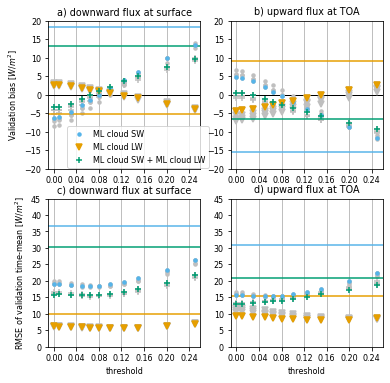

In [24]:
plt.rcParams['font.size'] = 8
plot_kwargs= {'ls': '-', 'lw': 0, 'ms': 6, 'mew': 1.5}

fig, axes = plt.subplots(2, 2)
ax0 = axes.flatten()[0]
ax0.plot([-0.01, 0.26], [0, 0], 'k-', lw=1)
ax0.plot(bias_df.iloc[2:]['threshold'].to_numpy(), bias_df.iloc[2:]['total_sky_downward_shortwave_flux_at_surface'].to_numpy(), '.', **plot_kwargs, color=[0.75, 0.75, 0.75])
ax0.plot(bias_df.iloc[2:]['threshold'].to_numpy(), bias_df.iloc[2:]['total_sky_downward_longwave_flux_at_surface'].to_numpy(), 'v', **plot_kwargs, color=[0.75, 0.75, 0.75])
ax0.plot(bias_df.iloc[2:]['threshold'].to_numpy(), bias_df.iloc[2:]['total_sky_downward_flux_at_surface'].to_numpy(), '+', **plot_kwargs, color=[0.75, 0.75, 0.75])
with modified_color_cycle(ax0, COLOR_CYCLE[:3]):
    ax0.plot(
        [-0.01, 0.26], 
        [bias_df.iloc[1]['total_sky_downward_shortwave_flux_at_surface'], bias_df.iloc[1]['total_sky_downward_shortwave_flux_at_surface']],
        '-'
    )
    ax0.plot(
        [-0.01, 0.26], 
        [bias_df.iloc[1]['total_sky_downward_longwave_flux_at_surface'], bias_df.iloc[1]['total_sky_downward_longwave_flux_at_surface']],
        '-'
    )
    ax0.plot(
        [-0.01, 0.26], 
        [bias_df.iloc[1]['total_sky_downward_flux_at_surface'], bias_df.iloc[1]['total_sky_downward_flux_at_surface']],
        '-'
    )
    h1, = ax0.plot(bias_df.iloc[2:13]['threshold'].to_numpy(), bias_df.iloc[2:13]['total_sky_downward_shortwave_flux_at_surface'].to_numpy(), '.', **plot_kwargs)
    h2, = ax0.plot(bias_df.iloc[2:13]['threshold'].to_numpy(), bias_df.iloc[2:13]['total_sky_downward_longwave_flux_at_surface'].to_numpy(), 'v', **plot_kwargs)
    h3, = ax0.plot(bias_df.iloc[2:13]['threshold'].to_numpy(), bias_df.iloc[2:13]['total_sky_downward_flux_at_surface'].to_numpy(), '+', **plot_kwargs)
ax0.grid(axis='x')
ax0.set_xlim([-0.01, 0.26])
ax0.set_xticks(np.linspace(0, 0.24, 7))
ax0.set_ylim([-20, 20])
ax0.set_ylabel(r'Validation bias [$W/{m^2}$]')
ax0.set_title('a) downward flux at surface')
ax0.legend([h1, h2, h3], ['ML cloud SW', 'ML cloud LW', 'ML cloud SW + ML cloud LW'], loc='lower right', bbox_to_anchor=[1.08, -0.02])
ax1 = axes.flatten()[1]
ax1.plot([-0.01, 0.26], [0, 0], 'k-', lw=1)
ax1.plot(bias_df.iloc[2:]['threshold'].to_numpy(), bias_df.iloc[2:]['total_sky_upward_shortwave_flux_at_top_of_atmosphere'].to_numpy(), '.', **plot_kwargs, color=[0.75, 0.75, 0.75])
ax1.plot(bias_df.iloc[2:]['threshold'].to_numpy(), bias_df.iloc[2:]['total_sky_upward_longwave_flux_at_top_of_atmosphere'].to_numpy(), 'v', **plot_kwargs, color=[0.75, 0.75, 0.75])
ax1.plot(bias_df.iloc[2:]['threshold'].to_numpy(), bias_df.iloc[2:]['total_sky_upward_flux_at_top_of_atmosphere'].to_numpy(), '+', **plot_kwargs, color=[0.75, 0.75, 0.75])
with modified_color_cycle(ax1, COLOR_CYCLE[:3]):
    ax1.plot(
        [-0.01, 0.26], 
        [bias_df.iloc[1]['total_sky_upward_shortwave_flux_at_top_of_atmosphere'], bias_df.iloc[1]['total_sky_upward_shortwave_flux_at_top_of_atmosphere']],
        '-'
    )
    ax1.plot(
        [-0.01, 0.26], 
        [bias_df.iloc[1]['total_sky_upward_longwave_flux_at_top_of_atmosphere'], bias_df.iloc[1]['total_sky_upward_longwave_flux_at_top_of_atmosphere']],
        '-'
    )
    ax1.plot(
        [-0.01, 0.26], 
        [bias_df.iloc[1]['total_sky_upward_flux_at_top_of_atmosphere'], bias_df.iloc[1]['total_sky_upward_flux_at_top_of_atmosphere']],
        '-'
    )
    ax1.plot(bias_df.iloc[2:13]['threshold'].to_numpy(), bias_df.iloc[2:13]['total_sky_upward_shortwave_flux_at_top_of_atmosphere'].to_numpy(), '.', **plot_kwargs)
    ax1.plot(bias_df.iloc[2:13]['threshold'].to_numpy(), bias_df.iloc[2:13]['total_sky_upward_longwave_flux_at_top_of_atmosphere'].to_numpy(), 'v', **plot_kwargs)
    ax1.plot(bias_df.iloc[2:13]['threshold'].to_numpy(), bias_df.iloc[2:13]['total_sky_upward_flux_at_top_of_atmosphere'].to_numpy(), '+', **plot_kwargs)
ax1.grid(axis='x')
ax1.set_xlim([-0.01, 0.26])
ax1.set_xticks(np.linspace(0, 0.24, 7))
ax1.set_ylim([-20, 20])
ax1.set_title('b) upward flux at TOA')
ax2 = axes.flatten()[2]
ax2.plot([-0.01, 0.26], [0, 0], 'k-', lw=1)
ax2.plot(rmse_df.iloc[2:]['threshold'].to_numpy(), rmse_df.iloc[2:]['total_sky_downward_shortwave_flux_at_surface'].to_numpy(), '.', **plot_kwargs, color=[0.75, 0.75, 0.75])
ax2.plot(rmse_df.iloc[2:]['threshold'].to_numpy(), rmse_df.iloc[2:]['total_sky_downward_longwave_flux_at_surface'].to_numpy(), 'v', **plot_kwargs, color=[0.75, 0.75, 0.75])
ax2.plot(rmse_df.iloc[2:]['threshold'].to_numpy(), rmse_df.iloc[2:]['total_sky_downward_flux_at_surface'].to_numpy(), '+', **plot_kwargs, color=[0.75, 0.75, 0.75])
with modified_color_cycle(ax2, COLOR_CYCLE[:3]):
    ax2.plot(
        [-0.01, 0.26], 
        [rmse_df.iloc[1]['total_sky_downward_shortwave_flux_at_surface'], rmse_df.iloc[1]['total_sky_downward_shortwave_flux_at_surface']],
        '-'
    )
    ax2.plot(
        [-0.01, 0.26], 
        [rmse_df.iloc[1]['total_sky_downward_longwave_flux_at_surface'], rmse_df.iloc[1]['total_sky_downward_longwave_flux_at_surface']],
        '-'
    )
    ax2.plot(
        [-0.01, 0.26], 
        [rmse_df.iloc[1]['total_sky_downward_flux_at_surface'], rmse_df.iloc[1]['total_sky_downward_flux_at_surface']],
        '-'
    )
    ax2.plot(rmse_df.iloc[2:13]['threshold'].to_numpy(), rmse_df.iloc[2:13]['total_sky_downward_shortwave_flux_at_surface'].to_numpy(), '.', **plot_kwargs)
    ax2.plot(rmse_df.iloc[2:13]['threshold'].to_numpy(), rmse_df.iloc[2:13]['total_sky_downward_longwave_flux_at_surface'].to_numpy(), 'v', **plot_kwargs)
    ax2.plot(rmse_df.iloc[2:13]['threshold'].to_numpy(), rmse_df.iloc[2:13]['total_sky_downward_flux_at_surface'].to_numpy(), '+', **plot_kwargs)
ax2.grid(axis='x')
ax2.set_xlim([-0.01, 0.26])
ax2.set_xticks(np.linspace(0, 0.24, 7))
ax2.set_xlabel('threshold')
ax2.set_ylim([0, 45])
ax2.set_ylabel(r'RMSE of validation time-mean [$W/{m^2}$]')
ax2.set_title('c) downward flux at surface')
ax3 = axes.flatten()[3]
ax3.plot([-0.01, 0.26], [0, 0], 'k-', lw=1)
ax3.plot(rmse_df.iloc[2:]['threshold'].to_numpy(), rmse_df.iloc[2:]['total_sky_upward_shortwave_flux_at_top_of_atmosphere'].to_numpy(), '.', **plot_kwargs, color=[0.75, 0.75, 0.75])
ax3.plot(rmse_df.iloc[2:]['threshold'].to_numpy(), rmse_df.iloc[2:]['total_sky_upward_longwave_flux_at_top_of_atmosphere'].to_numpy(), 'v', **plot_kwargs, color=[0.75, 0.75, 0.75])
ax3.plot(rmse_df.iloc[2:]['threshold'].to_numpy(), rmse_df.iloc[2:]['total_sky_upward_flux_at_top_of_atmosphere'].to_numpy(), '+', **plot_kwargs, color=[0.75, 0.75, 0.75])
with modified_color_cycle(ax3, COLOR_CYCLE[:3]):
    ax3.plot(
        [-0.01, 0.26], 
        [rmse_df.iloc[1]['total_sky_upward_shortwave_flux_at_top_of_atmosphere'], rmse_df.iloc[1]['total_sky_upward_shortwave_flux_at_top_of_atmosphere']],
        '-'
    )
    ax3.plot(
        [-0.01, 0.26], 
        [rmse_df.iloc[1]['total_sky_upward_longwave_flux_at_top_of_atmosphere'], rmse_df.iloc[1]['total_sky_upward_longwave_flux_at_top_of_atmosphere']],
        '-'
    )
    ax3.plot(
        [-0.01, 0.26], 
        [rmse_df.iloc[1]['total_sky_upward_flux_at_top_of_atmosphere'], rmse_df.iloc[1]['total_sky_upward_flux_at_top_of_atmosphere']],
        '-'
    )
    ax3.plot(rmse_df.iloc[2:13]['threshold'].to_numpy(), rmse_df.iloc[2:13]['total_sky_upward_shortwave_flux_at_top_of_atmosphere'].to_numpy(), '.', **plot_kwargs)
    ax3.plot(rmse_df.iloc[2:13]['threshold'].to_numpy(), rmse_df.iloc[2:13]['total_sky_upward_longwave_flux_at_top_of_atmosphere'].to_numpy(), 'v', **plot_kwargs)
    ax3.plot(rmse_df.iloc[2:13]['threshold'].to_numpy(), rmse_df.iloc[2:13]['total_sky_upward_flux_at_top_of_atmosphere'].to_numpy(), '+', **plot_kwargs)
ax3.grid(axis='x')
ax3.set_xlim([-0.01, 0.26])
ax3.set_xticks(np.linspace(0, 0.24, 7))
ax3.set_xlabel('threshold')
ax3.set_ylim([0, 45])
ax3.set_title('d) upward flux at TOA')
fig.set_size_inches([6, 6])
fig.savefig(f"./{OUTDIR}/thresholding_summary.eps", bbox_inches='tight')

In [27]:
varnames = [diag.python_diag_name + "_time_mean" for diag in FLUXES]

combined_biases = xr.concat([
    radiation_bias_time_mean_datasets['NN_seed_0_squash_threshold_0'][varnames].expand_dims({'run': ['ML cloud radiation bias']}),
    radiation_bias_time_mean_datasets['NN_seed_0_squash_threshold_0.065'][varnames].expand_dims({'run': ['Thresholded ML cloud\nradiation bias']}),
    (radiation_bias_time_mean_datasets['NN_seed_0_squash_threshold_0.065'] - radiation_bias_time_mean_datasets['NN_seed_0_squash_threshold_0'])[varnames].expand_dims({'run': ['Effect of ML cloud\nthresholding']}),

], dim='run').to_array(dim='variable_name', name='combined_biases')

combined_biases = combined_biases.assign_coords({
    'variable_name': [
        (
            name.item()
            .split('total_sky_')[1]
            .split('_time_mean')[0]
            .replace('_', ' ')
            .replace('x at', 'x\nat')
            .replace('shortwave', 'SW')
            .replace('longwave', 'LW')
        )
        for name in combined_biases.variable_name]
})

run_labels = combined_biases.stack({'panel': ['variable_name', 'run']}).panel.run
var_labels = combined_biases.stack({'panel': ['variable_name', 'run']}).panel.variable_name

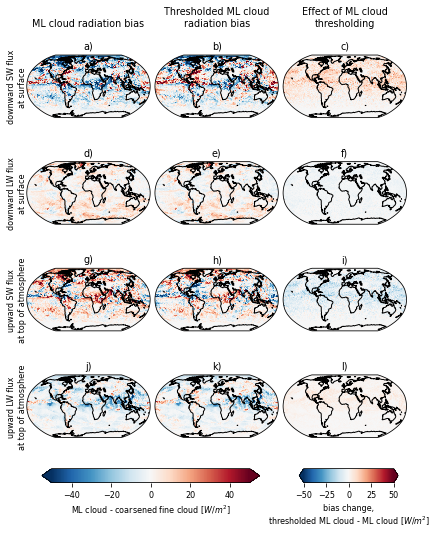

In [28]:
ncols = combined_biases.sizes['run']
fig, axes, handles, _, fg = fv3viz.plot_cube(
    xr.merge([
        combined_biases, GRID
    ]),
    'combined_biases',
    row='variable_name',
    col='run',
    vmin=-50,
    vmax=50,
    colorbar=None,
    rasterized=True
)
# unfortunately xarray's facetgrid label plotting is hard to control so do it ourselves
fg.set_titles('')
for i, ax in enumerate(axes.flatten()):
    run_title = f"{run_labels.isel(panel=[i]).item()}\n\n" if i < ncols else ''
    run_title += f"{ascii_lowercase[i]})"
    ax.set_title(run_title)
    if i % ncols == 0:
        variable_label = var_labels.isel(panel=[i]).item()
        ax.text(-0.08, 0.5, variable_label, transform=ax.transAxes, rotation='vertical', ha='center', va='center')
fig.subplots_adjust(bottom=0.08)
cb_ax = fig.add_axes([0.05, 0.03, 0.55, 0.03])
cbar = plt.colorbar(
    handles[0],
    cax=cb_ax,
    orientation='horizontal',
    extend="both",
    label=r"ML cloud - coarsened fine cloud [$W/{m^2}$]"
)
cb_ax2 = fig.add_axes([0.7, 0.03, 0.25, 0.03])
cbar = plt.colorbar(
    handles[0],
    cax=cb_ax2,
    orientation='horizontal',
    extend="both",
    label=(
        "bias change,\n"
        r"thresholded ML cloud - ML cloud [$W/{m^2}$]"
    )
)
fig.set_size_inches([5.5, 6.5])
fig.savefig(f'./{OUTDIR}/ml_cloud_radiation.pdf', bbox_inches='tight')